# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

Task: learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of DTP-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=18,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

## Test self-predicting dynamics (no target)

### Setup

In [2]:
# simulation settings

dt = 0.01 # in ms
tauxi = None
Tpres = 100 * dt
Ttot = 100 * Tpres # total simulation time

In [3]:
np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [0.0] * (len(layers) - 1)
eta_IP = [40.0] * (len(layers) - 1)
eta_PI = [50.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(-1, 1, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [4]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[0]))
r0_random = np.repeat(r0_random, int(Ttot / Tpres), axis=0)

In [5]:
mc1 = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

### Simulation

In [6]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
vapi_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i])
    
    uIbreve_time_series.append(copy.deepcopy(mc1.uI_breve))
    uPbreve_time_series.append(copy.deepcopy(mc1.uP_breve))
    rIbreve_time_series.append(copy.deepcopy(mc1.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc1.rP_breve))
    u_time_series.append(copy.deepcopy(mc1.get_voltages()))

    vapi_time_series.append(copy.deepcopy(mc1.vapi))
    WPP, WIP, BPP, BPI = mc1.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
        
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

### Evaluation

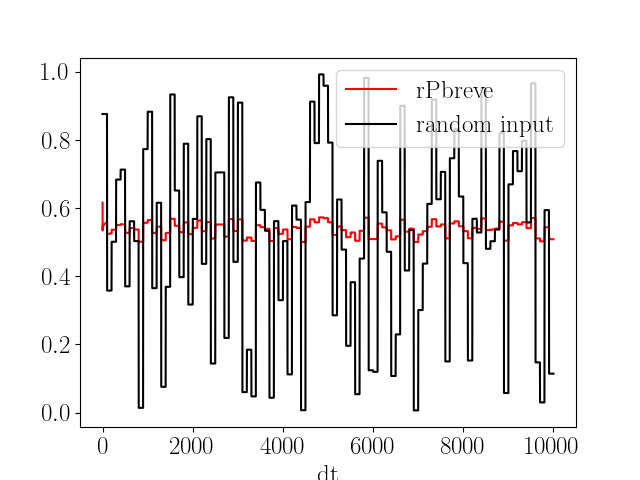

In [7]:
# Check that rP_breve correctly follows time scales of input

fig = plt.figure()
plt.plot(np.array([rPbreve[0] for rPbreve in rPbreve_time_series]).ravel(), label="rPbreve" , c='r')
# plt.plot(np.array([rIbreve[-1] for rIbreve in rIbreve_time_series]).ravel(), label="rIbreve" , c='b')
plt.plot(r0_random, label="random input", c='k')
plt.legend()
plt.xlabel('dt')
plt.show()

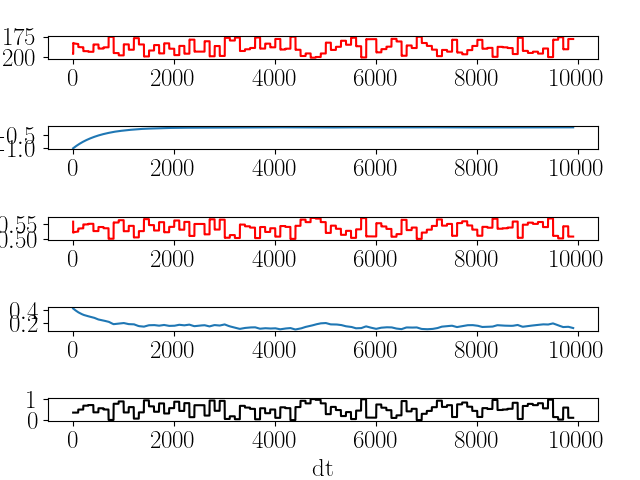

In [9]:
# in order to make this plot easier to read, we skip the first Tpres / dt samples

fig, ax = plt.subplots(len(uP_time_series[0]) + len(rPbreve_time_series[0]) + 1)

plt.tight_layout()

ax[len(ax)-1].plot(r0_random[int(Tpres/dt):], 'k')

for i in range(len(rPbreve_time_series[0])):
    rPbreve = np.array([rPbreve[i] for rPbreve in rPbreve_time_series[int(Tpres/dt):]])
    ax[len(ax)-2-2*i-1].plot(rPbreve, 'r')
    
for j in range(len(uP_time_series[0])):
    uP = np.array([uP[j] for uP in uP_time_series[int(Tpres/dt):]])
    ax[len(ax)-2-2*j].plot(uP)

plt.yscale('linear')

label = 'dt'
plt.xlabel(label)
# plt.legend()

plt.show()

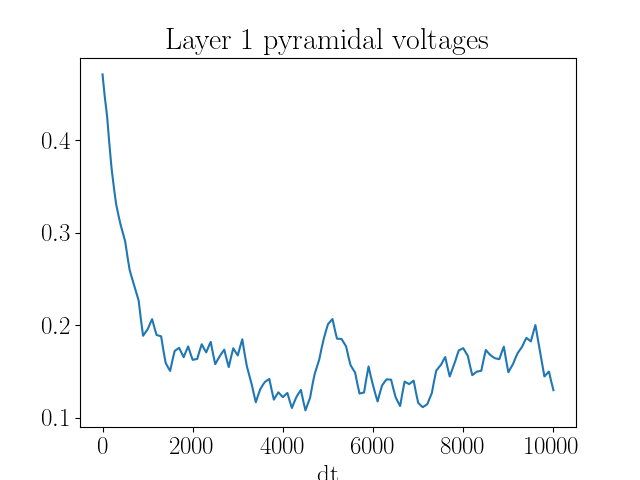

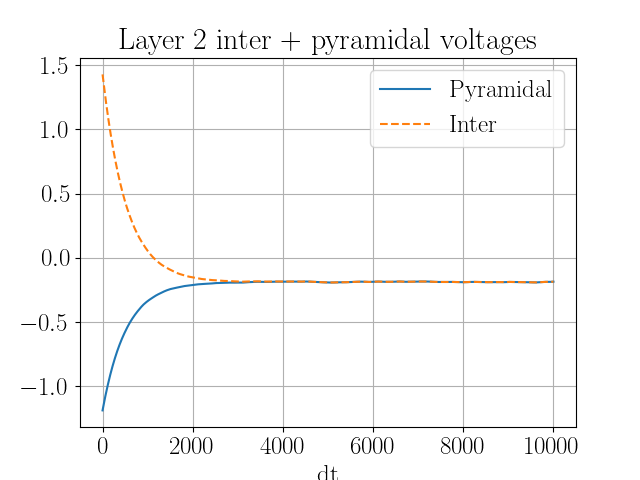

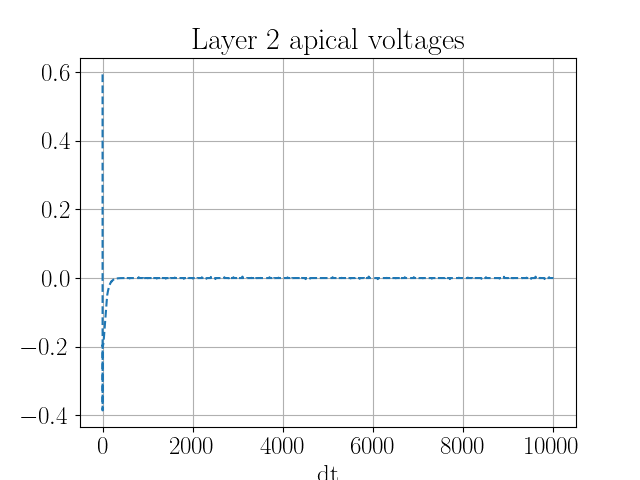

In [11]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    uP = np.array([uP[i] for uP in uP_time_series])
    ax.plot(uP)
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title(f'Layer {i+1} pyramidal voltages')
    plt.show()

# fig, ax = plt.subplots()
uI = np.array(uI_time_series).reshape(-1, np.array(uI_time_series).shape[-1])
# ax.plot(uI, '--')
# plt.yscale('linear')
# label = '$T_{ \mathrm{pres}} $'
# plt.xlabel(label)
# plt.title(f'Layer {len(layers)-1} interneuron voltages')
# plt.show()

fig, ax = plt.subplots()
uP = np.array([uP[-1] for uP in uP_time_series])
ax.plot(uP, label='Pyramidal')
ax.plot(uI, '--', label='Inter')
plt.yscale('linear')
label = 'dt'
plt.xlabel(label)
plt.title(f'Layer {len(layers)-1} inter + pyramidal voltages')
plt.grid()
plt.legend()
plt.show()


fig, ax = plt.subplots()
vapi = np.array(vapi_time_series).reshape(-1, np.array(uI_time_series).shape[-1])
ax.plot(vapi, '--')
# plt.yscale('log')
label = 'dt'
plt.xlabel(label)
plt.grid()
plt.title(f'Layer {len(layers)-1} apical voltages')
plt.show()

Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [12]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(len(BPI_time_series))
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(len(WIP_time_series))
                           ]))

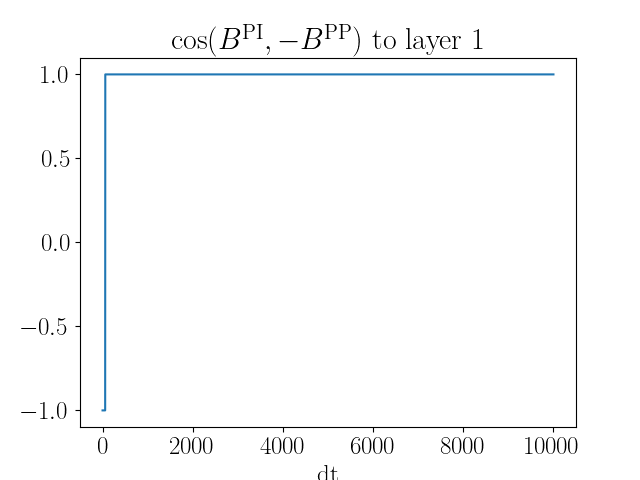

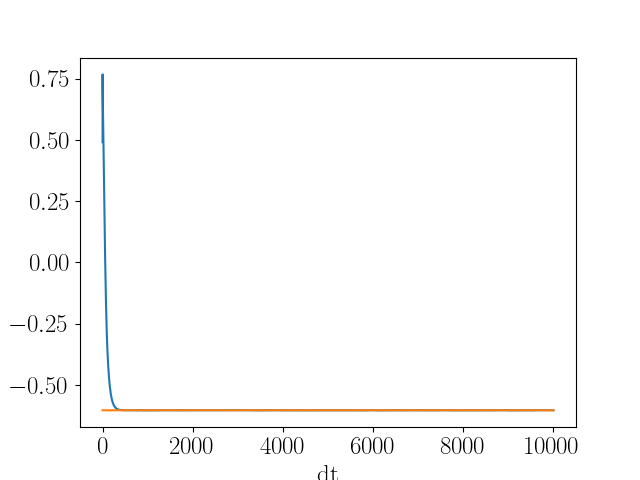

In [13]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()
    

fig, ax = plt.subplots()
ax.plot(np.array(BPI_time_series).ravel())
ax.plot(-np.array(BPP_time_series).ravel())
plt.yscale('linear')
label = 'dt'
plt.xlabel(label)
plt.ylabel("B")
# plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
plt.show()

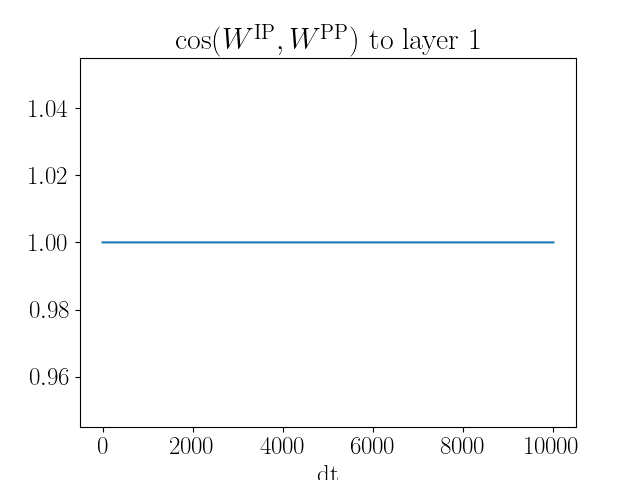

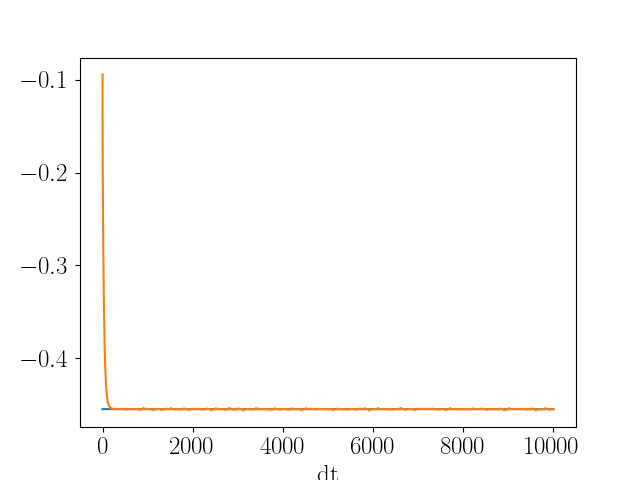

In [14]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()


fig, ax = plt.subplots()
ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
ax.plot(np.array(WIP_time_series).ravel())
plt.yscale('linear')
label = 'dt'
plt.xlabel(label)
plt.show()

## Test learning of WPP with FA

In order to test if the microcircuit can learn, we train a network with FA to reproduce the input/output combinations of a teacher net.

In [2]:
# simulation settings

dt = 0.01 # in ms
tauxi = None
Tpres = 100 * dt
Ttot = 100 * Tpres # simulation time per epoch

epochs = 50

In [3]:
## Init for teacher

np.random.seed(5678)

# Init model: weights, voltages

layers = [1, 1, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1) # disable all lr for teacher
eta_bw = [0.0] * (len(layers) - 1)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(-1, 1, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [4]:
# We initialise the teacher in the self-predicting state

mc2_teacher = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc2_teacher.set_self_predicting_state()

In [5]:
## Init for student

np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [200.0, 50.0] # This is the crucial difference
eta_bw = [0.0] * (len(layers) - 1)
eta_IP = [150.0, 20.0]
eta_PI = [0.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(-1, 1, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [6]:
# We also initialise the student in the self-predicting state

mc2_student = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=mc2_teacher.BPP, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc2_student.set_self_predicting_state()

Note that the weights are initialised differenly:

In [7]:
mc2_teacher.WPP

[array([[0.19645002]]), array([[-0.13877101]])]

In [8]:
mc2_student.WPP

[array([[0.55995162]]), array([[-0.45481479]])]

But the backwards weights are the same:

In [9]:
mc2_teacher.BPP

[array([[-0.4294922]])]

In [10]:
mc2_student.BPP

[array([[-0.4294922]])]

Setting the self-predicting state also fixes BPI:

In [11]:
mc2_teacher.BPI

[array([[0.4294922]])]

In [12]:
mc2_student.BPI

[array([[0.4294922]])]

Now, we show random samples for t=Tpres to the teacher and record the output

In [13]:
r0_random = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[0]))
r0_random = np.repeat(r0_random, int(Ttot / Tpres), axis=0)

# u2P of teacher will be target for student
target_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc2_teacher.evolve_system(r0=r0_random[i])

# run real evaluation and save output
for i in range(len(r0_random)):
    mc2_teacher.evolve_system(r0=r0_random[i])
    target_time_series.append(copy.deepcopy(mc2_teacher.uP_breve[1]))

target_time_series = np.array(target_time_series)

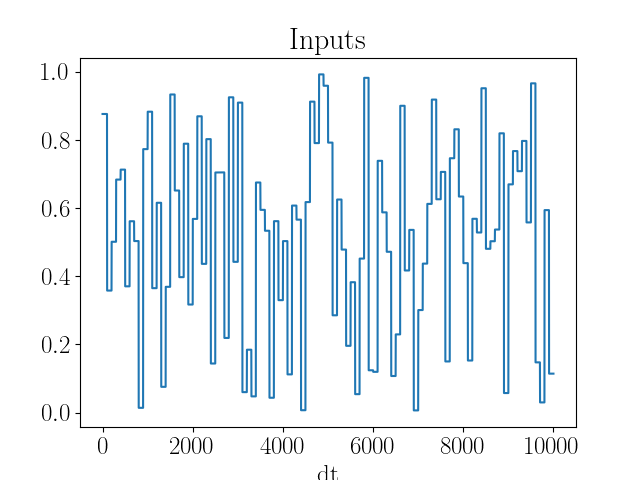

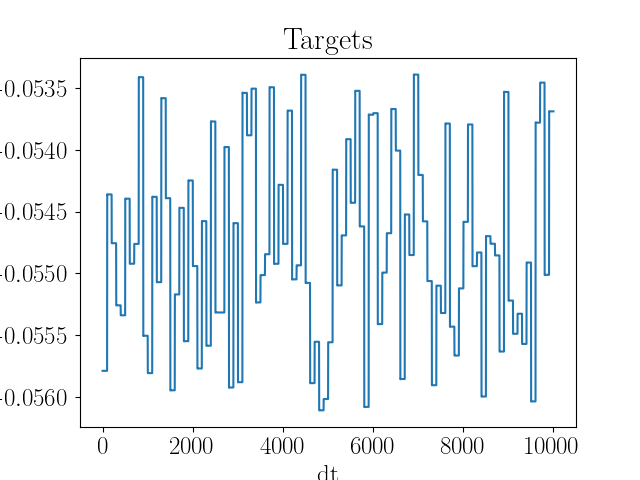

In [14]:
fig = plt.figure()
plt.plot(r0_random)
plt.title("Inputs")
plt.xlabel("dt")
plt.show()

fig = plt.figure()
plt.plot(target_time_series)
plt.title("Targets")
plt.xlabel("dt")
plt.show()

In [15]:
# now, we give the same input to the student

u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
vapi_time_series = []
vbas_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc2_student.evolve_system(r0=r0_random[i])

for j in range(epochs):
# for j in range(1):
    # if j % epochs == 0:
    print(f"Training epoch {j}")
    for i in range(len(r0_random)):
        mc2_student.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]])

        uIbreve_time_series.append(copy.deepcopy(mc2_student.uI_breve))
        uPbreve_time_series.append(copy.deepcopy(mc2_student.uP_breve))
        # rIbreve_time_series.append(copy.deepcopy(mc2_student.rI_breve))
        # rPbreve_time_series.append(copy.deepcopy(mc2_student.rP_breve))
        # u_time_series.append(copy.deepcopy(mc2_student.get_voltages()))

        # vapi_time_series.append(copy.deepcopy(mc2_student.vapi))
        # vbas_time_series.append(copy.deepcopy(mc2_student.vbas))
        WPP, WIP, BPP, BPI = mc2_student.get_weights()
        WPP_time_series.append(copy.deepcopy(WPP))
        # BPP_time_series.append(copy.deepcopy(BPP))
        # WIP_time_series.append(copy.deepcopy(WIP))
        # BPI_time_series.append(copy.deepcopy(BPI))
        
# uP_time_series = [u[0] for u in u_time_series]
# uI_time_series = [u[1] for u in u_time_series]

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49


output layer, neuron 0


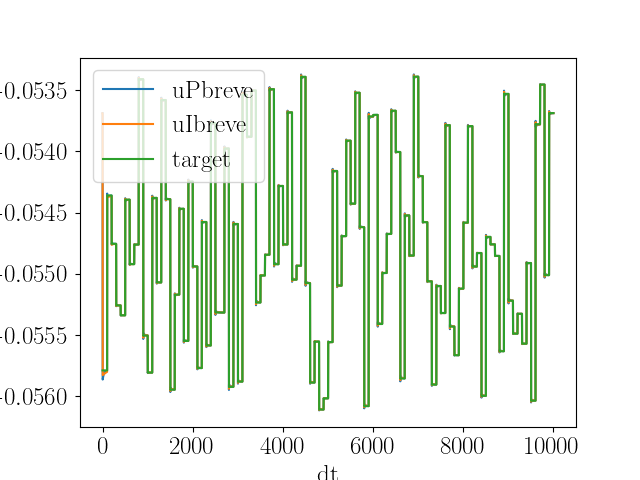

In [16]:
for i in range(layers[-1]):
    print("output layer, neuron", i)
    fig = plt.figure()
    uP2 = np.array([uP_breve[1][i] for uP_breve in uPbreve_time_series[-len(target_time_series):]])
    plt.plot(uP2, label="uPbreve")
    uI2 = np.array([uI_breve[0][i] for uI_breve in uIbreve_time_series[-len(target_time_series):]])
    plt.plot(uI2, label="uIbreve")
    plt.plot([target[i] for target in target_time_series], label="target")
    # plt.plot(target_time_series-uP2.ravel(), label="tgt-uP")
    plt.xlabel("dt")
    plt.legend()
    plt.show()

neuron 0


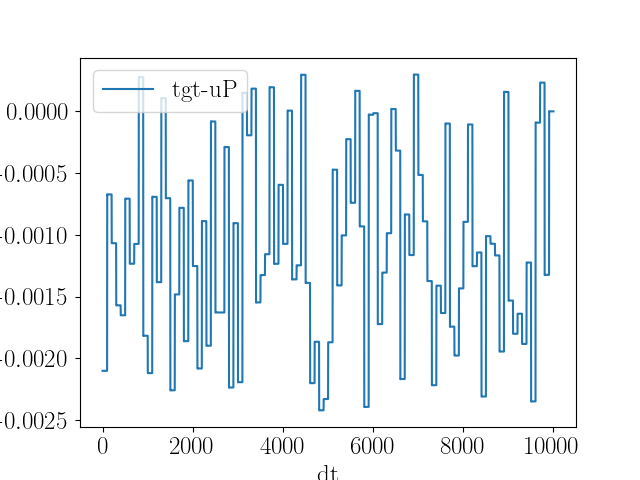

In [17]:
for i in range(layers[-1]):
    print("neuron", i)

    fig = plt.figure()
    uP2 = np.array([uP_breve[1][i] for uP_breve in uPbreve_time_series[-len(target_time_series):]])
    plt.plot([target[i] for target in target_time_series] - uP2[i], label="tgt-uP")
    plt.xlabel("dt")
    plt.legend()
    plt.show()

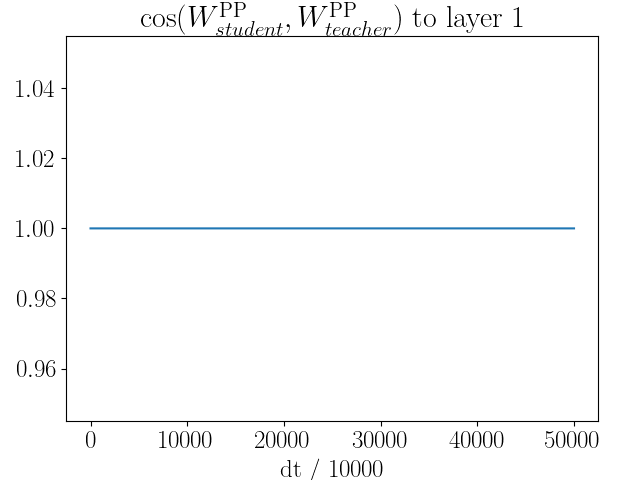

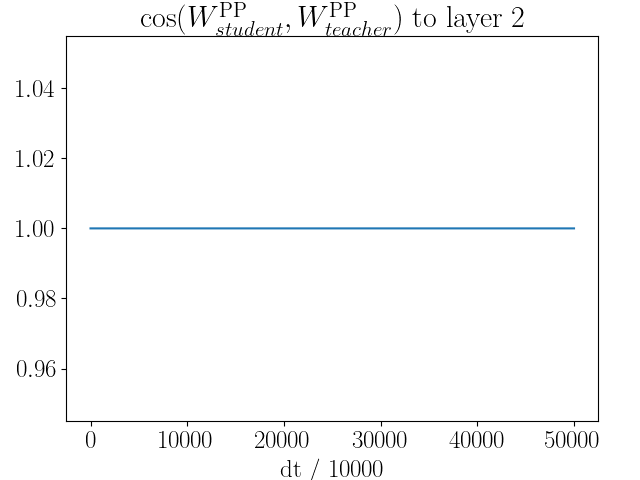

In [18]:
cos_WPP_stud_teach = []
for i in range(len(WPP_time_series[0])):
    cos_WPP_stud_teach.append(np.array([
        cos_sim(WPP_time_series[j][i], mc2_teacher.WPP[i]) for j in range(0,len(WPP_time_series),10)
                           ]))
    
for i in range(len(cos_WPP_stud_teach)):
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.plot(cos_WPP_stud_teach[i])
    plt.yscale('linear')
    label = 'dt / 10000'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{PP}_{student}, W^\mathrm{PP}_{teacher})$ to layer ' + str(i+1))
    plt.show()

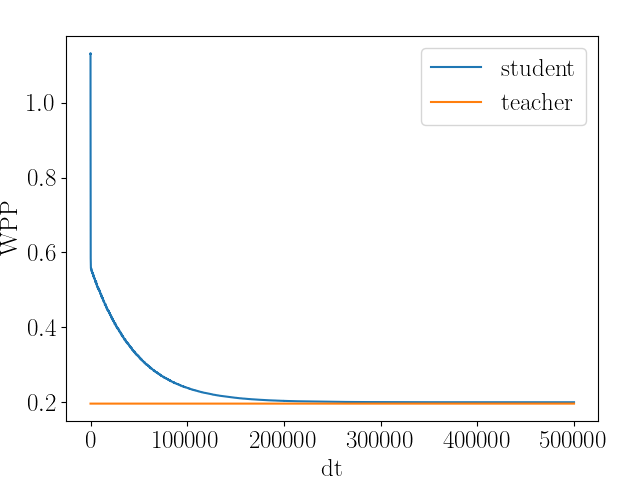

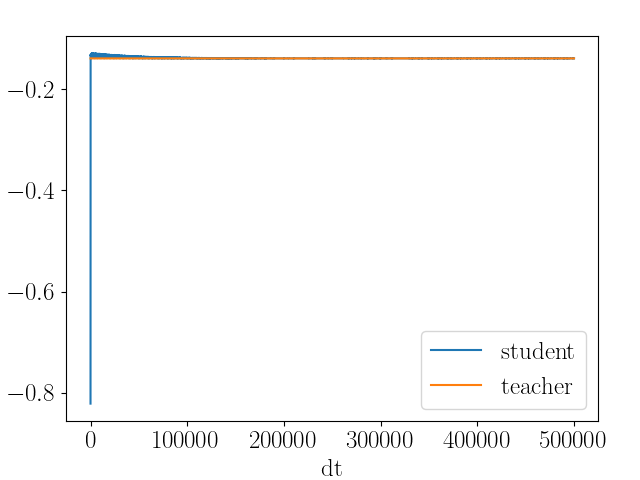

In [24]:
for i in range(len(WPP_time_series[0])):
    fig, ax = plt.subplots()
    plt.tight_layout()
    WPP = np.array([WPP[i] for WPP in WPP_time_series]).ravel()
    ax.plot(WPP, label="student")
    ax.plot(np.array(mc2_teacher.WPP[i])[0]*np.ones_like(WPP), label="teacher")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.legend()
    plt.ylabel("WPP")
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

## Test learning of WPP with BP, incl. sign flip

In order to test if the microcircuit can learn, we train a network with FA to reproduce the input/output combinations of a teacher net.

In [49]:
# simulation settings

dt = 0.01 # in ms
tauxi = None
Tpres = 100 * dt
Ttot = 100 * Tpres # simulation time per epoch

epochs = 20

In [50]:
## Init for teacher

np.random.seed(56789)

# Init model: weights, voltages

layers = [1, 2, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1) # disable all lr for teacher
eta_bw = [0.0] * (len(layers) - 1)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(-1, 0, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
# Note: we init B < 0
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(0, +1, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [51]:
# We initialise the teacher in the self-predicting state

mc3_teacher = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_teacher.set_self_predicting_state()

In [94]:
## Init for student

np.random.seed(12345)

# Init model: weights, voltages

# layers = [2, 2, 2]
layers = [1, 2, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [100.0, 20.0] # This is the crucial difference
eta_bw = [0.0] * (len(layers) - 1)
eta_IP = [80.0, 20.0]
eta_PI = [50.0]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
# Note: we init W > 0
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
# Note: we init B < 0
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [95]:
# We also initialise the student in the self-predicting state

mc3_student_BP = model(dt, tauxi, Tpres, 'BP', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=None, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_BP.set_self_predicting_state()

mc3_student_FA = model(dt, tauxi, Tpres, 'FA', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=mc3_teacher.BPP, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc3_student_FA.set_self_predicting_state()

In [96]:
r0_random = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[0]))
r0_random = np.repeat(r0_random, int(Ttot / Tpres), axis=0)

# u2P of teacher will be target for student
target_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc3_teacher.evolve_system(r0=r0_random[i])

# run real evaluation and save output
for i in range(len(r0_random)):
    mc3_teacher.evolve_system(r0=r0_random[i])
    target_time_series.append(copy.deepcopy(mc3_teacher.uP_breve[1]))

target_time_series = np.array(target_time_series)

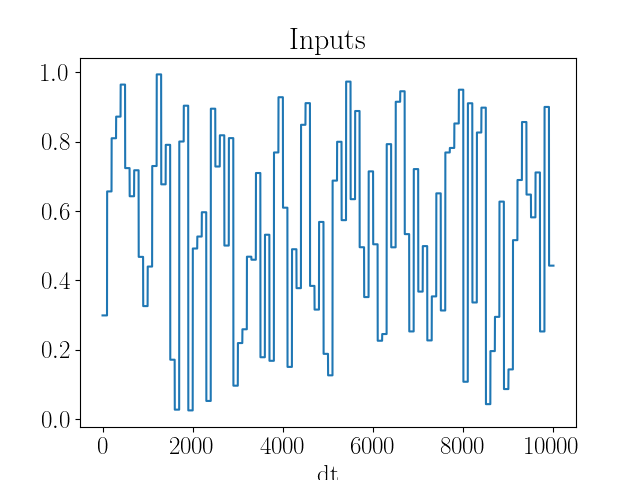

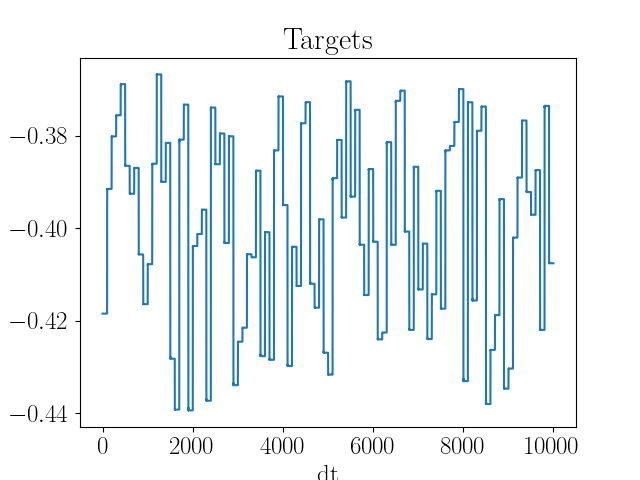

In [97]:
fig = plt.figure()
plt.plot(r0_random)
plt.title("Inputs")
plt.xlabel("dt")
plt.show()

fig = plt.figure()
plt.plot(target_time_series)
plt.title("Targets")
plt.xlabel("dt")
plt.show()

In [88]:
# now, we give the same input to the FA student

uIbreve_FA_time_series = []
uPbreve_FA_time_series = []
WPP_FA_time_series = []
loss_FA_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc3_student_FA.evolve_system(r0=r0_random[i])

for j in range(epochs):
    print(f"Training epoch {j}")
    loss = 0.0
    for i in range(len(r0_random)):
        mc3_student_FA.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]])
        loss += MSE(mc3_student_FA.uP_breve[-1], target_time_series[-1]) / len(r0_random)

        uIbreve_FA_time_series.append(copy.deepcopy(mc3_student_FA.uI_breve))
        uPbreve_FA_time_series.append(copy.deepcopy(mc3_student_FA.uP_breve))
        WPP, _, _, _, = mc3_student_FA.get_weights()
        WPP_FA_time_series.append(copy.deepcopy(WPP))
    loss_FA_time_series.append(loss)

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19


In [98]:
# now, we give the same input to the BP student

uIbreve_BP_time_series = []
uPbreve_BP_time_series = []
WPP_BP_time_series = []
loss_BP_time_series = []

# a little pre-training: run for one Tpres with random input, such that the
# somatic voltages converge
for i in range(int(Tpres/dt)):
    mc3_student_BP.evolve_system(r0=r0_random[i])

for j in range(epochs):
    print(f"Training epoch {j}")
    loss = 0.0
    for i in range(len(r0_random)):
        mc3_student_BP.evolve_system(r0=r0_random[i], u_tgt=[target_time_series[i]])
        loss += MSE(mc3_student_BP.uP_breve[-1], target_time_series[-1]) / len(r0_random)

        uIbreve_BP_time_series.append(copy.deepcopy(mc3_student_BP.uI_breve))
        uPbreve_BP_time_series.append(copy.deepcopy(mc3_student_BP.uP_breve))
        WPP, _, _, _, = mc3_student_BP.get_weights()
        WPP_BP_time_series.append(copy.deepcopy(WPP))
    loss_BP_time_series.append(loss)

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19


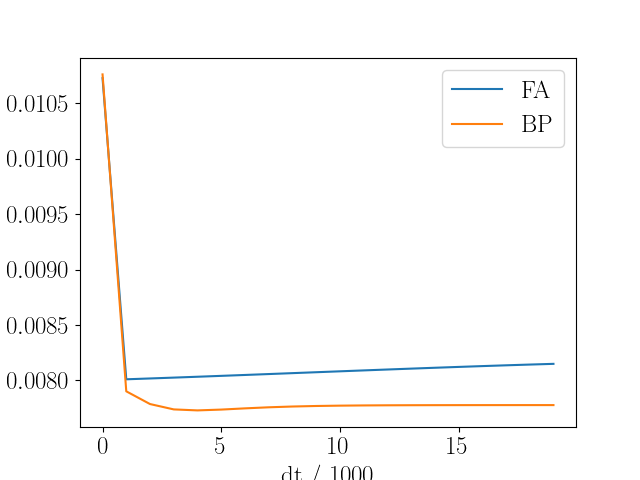

In [99]:
fig, ax = plt.subplots()
# plt.tight_layout()
ax.plot(loss_FA_time_series, label="FA")
ax.plot(loss_BP_time_series, label="BP")
plt.yscale('linear')
label = 'dt / 1000'
plt.xlabel(label)
plt.ylabel("loss")
plt.legend()
# plt.title('$\cos(W^\mathrm{PP}_{student}, W^\mathrm{PP}_{teacher})$ to layer ' + str(i+1))
plt.show()

In [100]:
# cos_FA_WPP_stud_teach = []
# for i in range(len(WPP_FA_time_series[0])):
#     cos_FA_WPP_stud_teach.append(np.array([
#         cos_sim(WPP_FA_time_series[j][i], mc3_teacher.WPP[i]) for j in range(0,len(WPP_FA_time_series),100)
#                            ]))
    
# cos_BP_WPP_stud_teach = []
# for i in range(len(WPP_BP_time_series[0])):
#     cos_BP_WPP_stud_teach.append(np.array([
#         cos_sim(WPP_BP_time_series[j][i], mc3_teacher.WPP[i]) for j in range(0,len(WPP_BP_time_series),100)
#                            ]))
    
# for i in range(len(cos_FA_WPP_stud_teach)):
#     fig, ax = plt.subplots()
#     # plt.tight_layout()
#     ax.plot(cos_FA_WPP_stud_teach[i], label="FA")
#     ax.plot(cos_BP_WPP_stud_teach[i], label="BP")
#     plt.yscale('linear')
#     label = 'dt / 1000'
#     plt.xlabel(label)
#     plt.legend()
#     plt.title('$\cos(W^\mathrm{PP}_{student}, W^\mathrm{PP}_{teacher})$ to layer ' + str(i+1))
#     plt.show()

output layer, neuron 0 FA


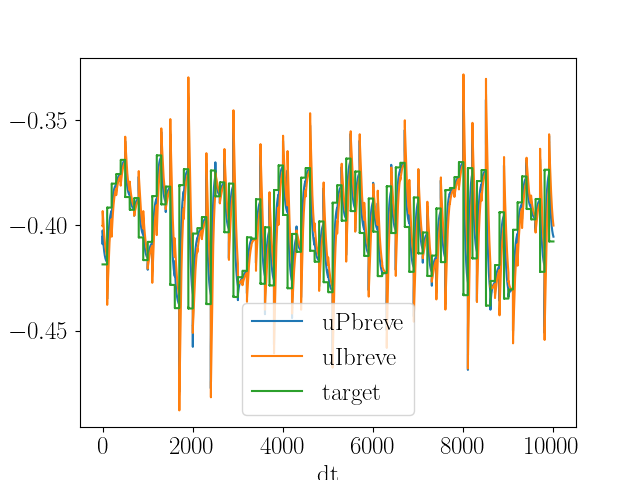

In [101]:
for i in range(layers[-1]):
    print("output layer, neuron", i, "FA")
    fig = plt.figure()
    uP2 = np.array([uP_breve[1][i] for uP_breve in uPbreve_FA_time_series[-len(target_time_series):]])
    plt.plot(uP2, label="uPbreve")
    uI2 = np.array([uI_breve[0][i] for uI_breve in uIbreve_FA_time_series[-len(target_time_series):]])
    plt.plot(uI2, label="uIbreve")
    plt.plot([target[i] for target in target_time_series], label="target")
    # plt.plot(target_time_series-uP2.ravel(), label="tgt-uP")
    plt.xlabel("dt")
    plt.legend()
    plt.show()

output layer, neuron 0 BP


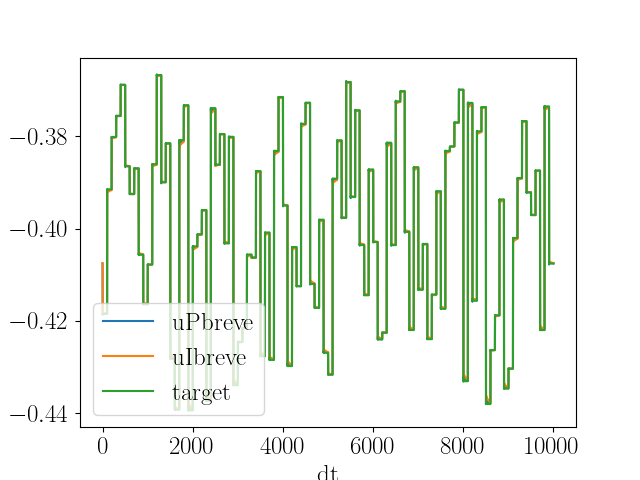

In [102]:
for i in range(layers[-1]):
    print("output layer, neuron", i, "BP")
    fig = plt.figure()
    uP2 = np.array([uP_breve[1][i] for uP_breve in uPbreve_BP_time_series[-len(target_time_series):]])
    plt.plot(uP2, label="uPbreve")
    uI2 = np.array([uI_breve[0][i] for uI_breve in uIbreve_BP_time_series[-len(target_time_series):]])
    plt.plot(uI2, label="uIbreve")
    plt.plot([target[i] for target in target_time_series], label="target")
    # plt.plot(target_time_series-uP2.ravel(), label="tgt-uP")
    plt.xlabel("dt")
    plt.legend()
    plt.show()